In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, UTC
from sqlalchemy.orm import Session

from ionbeam.core.time import (
    TimeSpan,
    collapse_time_spans_upto_max,
    split_df_into_time_chunks,
)

def plot_spans(spans, ax = None, shade_colour = "green", label = None):
    if ax is None: f, ax = plt.subplots(1, 1, figsize = (10, 2))
    
    for ts in spans:
            ax.axvline(ts.start, linestyle = "dotted", color = "green")
            ax.axvline(ts.end, linestyle = "solid", color = "orange")
            ax.axvspan(ts.start, ts.end, alpha = 0.1, color = shade_colour, label = label)
    return ax

In [3]:
import logging 

logging.basicConfig(
    level=logging.DEBUG,
)
import matplotlib
matplotlib.pyplot.set_loglevel("warning")

In [4]:
from ionbeam.sources.API_sources_base import DataChunk, DBDataChunk, DataStream
from ionbeam.core import parse_single_action, parse_config
from pathlib import Path

config_file = Path("~/git/IonBeam_bundle/IonBeam/config").expanduser()

action_yaml = """
class: AcronetSource
"""

config, source = parse_single_action(config_file, action_yaml, 
                        offline = False,
                        environment  = "local",
                        die_on_error = False,
                                    )

DEBUG:ionbeam.core.config_parser.config_parser:Configuration Directory: /Users/math/git/IonBeam_bundle/IonBeam/config
DEBUG:ionbeam.core.config_parser.config_parser:Global config file: /Users/math/git/IonBeam_bundle/IonBeam/config/config.yaml
DEBUG:ionbeam.core.config_parser.config_parser:Loaded global config...
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.data_path to /Users/math/git/IonBeam_bundle/data
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.cache_path to /Users/math/git/IonBeam_bundle/data/cache
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.fdb_schema_path to /Users/math/git/IonBeam_bundle/IonBeam/config/schema
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.fdb_root to /Users/math/git/IonBeam_bundle/data/fdb_root
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.metkit_language_template to /Users/math/git/IonBeam_bundle/IonBeam/config/language.yaml.template


In [6]:
from pprint import pprint

now = datetime.now(UTC)

show_time_span = TimeSpan.last(days = 200)

query_time_span = TimeSpan(start = now - timedelta(days = 3), end = now)

data_streams = list(source.get_data_streams(show_time_span))

data_streams = data_streams[:4]

for ds in data_streams:
    pprint(ds)

DataStream(source='acronet',
           key='acronet:PLUVIOMETRO',
           version=1,
           data=GenericSensor(unit='mm',
                              name='PLUVIOMETRO',
                              translation='RAIN_GAUGE'))
DataStream(source='acronet',
           key='acronet:TERMOMETRO',
           version=1,
           data=GenericSensor(unit='°C',
                              name='TERMOMETRO',
                              translation='TEMPERATURE'))
DataStream(source='acronet',
           key='acronet:IGROMETRO',
           version=1,
           data=GenericSensor(unit='%',
                              name='IGROMETRO',
                              translation='HYGROMETER'))
DataStream(source='acronet',
           key='acronet:DIREZIONEVENTO',
           version=1,
           data=GenericSensor(unit='Degrees',
                              name='DIREZIONEVENTO',
                              translation='WIND_DIRECTION'))


gap: 10 days, 0:00:00
gap: 5 days, 23:26:29.935472
gap: 3 days, 20:52:14.573726
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 5 days, 23:23:35.678444
gap: 3 days, 20:52:14.573726
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 5 days, 23:23:35.678444
gap: 3 days, 20:52:14.573726
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 10 days, 0:00:00
gap: 5 days, 23:23:35.678444
gap: 3 days, 20:52:14.573726


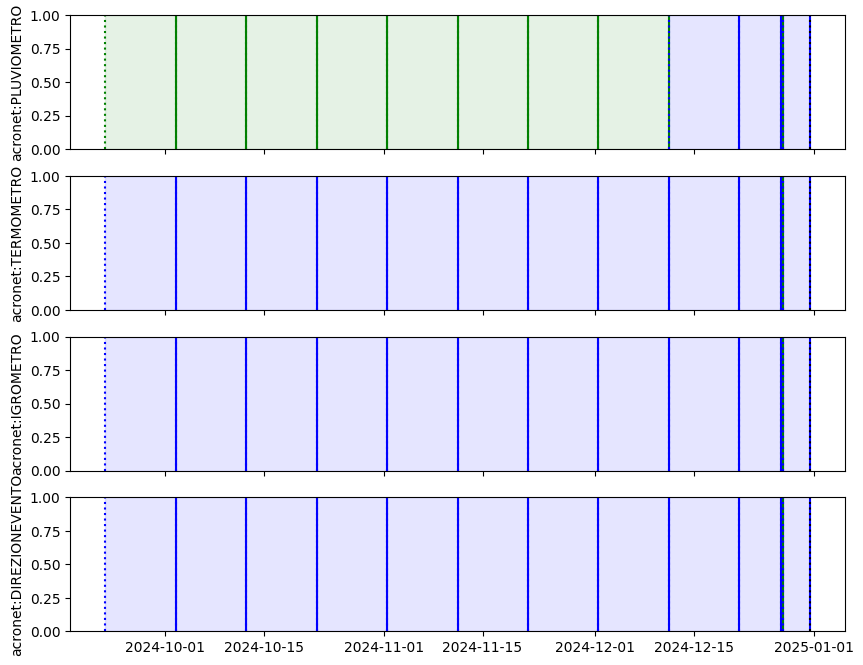

In [17]:
n = len(data_streams)
f, axes = plt.subplots(n, 1, figsize = (10, 2*n), sharex = True)

def plot_timespan(ax, ts, colour, label = None):
    ax.axvline(ts.start, linestyle = "dotted", color = colour)
    ax.axvline(ts.end, linestyle = "solid", color = colour)
    ax.axvspan(ts.start, ts.end, alpha = 0.1, color = colour, label = label)

with Session(config.globals.sql_engine) as db_session:
    for ds, ax in zip(data_streams, axes):
        existing_chunks = ds.get_chunks_from_db(db_session, show_time_span)
        
        for chunk in existing_chunks:
            if not chunk.success:
                pprint(chunk)
            colour = "red" if not chunk.success else "green"
            label = "Failed" if not chunk.success else "Sucess"
            plot_timespan(ax, chunk.time_span, colour, label = label)
        
        gaps = source.gaps_in_database(db_session, ds, query_time_span)
        for ts in gaps: 
            print(f"gap: {ts.delta()}")
            plot_timespan(ax, ts, "blue", label = "Todo")

        ax.axvline(datetime.now(UTC), linestyle = "dotted", color = "k")
        ax.set(ylabel = ds.key)
# ax.legend()

In [8]:
import requests
from requests.structures import CaseInsensitiveDict

# Create a Response object
response = requests.Response()

# Populate response with desired status code and headers
response.status_code = 429
response.reason = "Too Many Requests"
response.headers = CaseInsensitiveDict({"Retry-After": "60"})

# Construct the HTTPError using the response
too_many_requsts_error = requests.exceptions.HTTPError(
    f"{response.status_code} {response.reason}",
    response=response
)

In [11]:
now = datetime.now(UTC)
query_time_span = TimeSpan(start = now - timedelta(days = 100), end = now)

downloaded_chunks = list(source.download_data(data_streams, query_time_span, 
                                              # fail = too_many_requsts_error
                                             ))

DEBUG:ionbeam.sources.cima.source:Downloading all data in timespan for sensor_class = PLUVIOMETRO
DEBUG:ionbeam.sources.API_sources_base:Downloaded data and wrote to db for acronet:PLUVIOMETRO 2024-11-11T10:51:25.265419+00:00 - 2024-11-21T10:51:25.265419+00:00
DEBUG:ionbeam.sources.cima.source:Downloading all data in timespan for sensor_class = PLUVIOMETRO
DEBUG:ionbeam.sources.API_sources_base:Downloaded data and wrote to db for acronet:PLUVIOMETRO 2024-11-21T10:51:25.265419+00:00 - 2024-12-01T10:51:25.265419+00:00
DEBUG:ionbeam.sources.cima.source:Downloading all data in timespan for sensor_class = PLUVIOMETRO
DEBUG:ionbeam.sources.API_sources_base:Downloaded data and wrote to db for acronet:PLUVIOMETRO 2024-12-01T10:51:25.265419+00:00 - 2024-12-11T10:51:25.265419+00:00
DEBUG:ionbeam.sources.cima.source:Downloading all data in timespan for sensor_class = PLUVIOMETRO


KeyboardInterrupt: 

In [ ]:
# with Session(config.globals.sql_engine) as db_session:
#     for dc in db_session.query(DBDataChunk).all():
#         db_session.delete(dc)
#     db_session.commit()